# COURSERA CAPSTONE FINAL PROJECT, WEEKS 4 & 5

## Find the best location to open a fitness nutrition shop in a shopping mall in Toronto

## Import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Import and explore Toronto postalcode areas

In [2]:
# import data frame
df=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [3]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with Neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Define Foursquare Credentials and Version

In [6]:
# Note that these credentials are saved in Credentials.csv which is not shared on github
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43'#Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [8]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [9]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [10]:
category_list = category_results['response']['categories']
len(category_list)

10

In [11]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [12]:
Sport_ID='4d4b7105d754a06377d81259'
Shop_ID='4d4b7105d754a06378d81259'

**_Outdoors & Recreation_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [13]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [14]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = Sport_ID)

In [15]:
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts Dojo',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d102941735

Now, we have all the categories in _Outdooes and recreation_ with their id's.

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [16]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [17]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Now, let's get the _Sport & Recreation_ that is in this neighborhood within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [18]:
LIMIT = 10 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = Sport_ID # category ID for "sport and recreation"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L&client_secret=TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43&v=20180604&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06377d81259&limit=10'

Send the GET request and examine the resutls

In [19]:
results = requests.get(url).json()

In [20]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589493812',
 'hasPerk': False}

The category name of the venue **'Brookbanks Park'** is **'Parks'**.

As, our aim is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

In [21]:
def getNearbyVenues(ID, names, latitudes, longitudes, radius=2500, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            ID, # category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [22]:
import pickle # to serialize and deserialize a Python object structure

# get all sport venues
try:
    with open('Toronto_venues_sport.pkl', 'rb') as f:
        Toronto_venues_sport = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_sport = getNearbyVenues(ID=Sport_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_sport.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_sport, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [23]:
# get all shop venues
try:
    with open('Toronto_venues_shop.pkl', 'rb') as f:
        Toronto_venues_shop = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_shop = getNearbyVenues(ID=Shop_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_shop.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_shop, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


## 3. Analysis & Machine Learning

#### Let's find out how many unique categories can be curated from all the returned sport venues

In [24]:
print('There are {} uniques categories.'.format(len(Toronto_venues_sport['Venue Category'].unique())))
Toronto_venues_sport.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 94 uniques categories.


Venue Category
Park                                        1479
Gym                                          304
Playground                                   239
Gym / Fitness Center                         194
Other Great Outdoors                         149
Trail                                        145
Athletics & Sports                           123
Garden                                       108
Pool                                         106
Bridge                                       103
Skating Rink                                 100
Plaza                                         86
Dog Run                                       86
Baseball Field                                77
Tennis Court                                  62
Beach                                         62
Martial Arts Dojo                             60
Yoga Studio                                   58
Field                                         55
Golf Course                                   54
Socce

In [25]:
# manually create a list of desired sport related categories (> 20 venues)
sport_categories = ['Gym','Gym / Fitness Center','Athletics & Sports','Pool','Skating Rink','Baseball Field',
                   'Tennis Court','Martial Arts Dojo','Yoga Studio','Golf Course','Soccer Field']

Revise the results to keep only venues in the list of sport categories

In [26]:
Toronto_venues_sport = Toronto_venues_sport[Toronto_venues_sport['Venue Category'].isin(sport_categories)].reset_index()
Toronto_venues_sport.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,7,Parkwoods,43.753259,-79.329656,Venus Concept Gym,43.770232,-79.330044,Gym
1,8,Parkwoods,43.753259,-79.329656,Socacize Bootcamp Scarborough,43.771599,-79.334302,Gym / Fitness Center
2,14,Parkwoods,43.753259,-79.329656,Shendy's Swim Centre,43.745781,-79.353354,Pool
3,15,Parkwoods,43.753259,-79.329656,Breaker Strength CrossFit,43.757506,-79.359207,Athletics & Sports
4,16,Parkwoods,43.753259,-79.329656,Maryvale Wading Pool,43.753495,-79.305988,Pool


#### Let's find out how many unique categories can be curated from all the returned shop venues

In [27]:
print('There are {} uniques categories.'.format(len(Toronto_venues_shop['Venue Category'].unique())))
Toronto_venues_shop.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 121 uniques categories.


Venue Category
Grocery Store                               851
Pharmacy                                    524
Gas Station                                 384
Supermarket                                 384
Shopping Mall                               349
Liquor Store                                230
Hardware Store                              173
Discount Store                              173
Bank                                        166
Convenience Store                           120
Automotive Shop                              91
Electronics Store                            71
Gourmet Shop                                 66
Furniture / Home Store                       65
Shopping Plaza                               57
Building                                     55
Beer Store                                   48
Auto Garage                                  46
Miscellaneous Shop                           44
Fast Food Restaurant                         39
Salon / Barbershop       

In [28]:
# manually create a list of desired shop related categories
shop_categories = ['Shopping Mall','Shopping Plaza','Sporting Goods Shop']

Revise the results to keep only venues in the list of sport categories

In [29]:
Toronto_venues_shop = Toronto_venues_shop[Toronto_venues_shop['Venue Category'].isin(shop_categories)].reset_index()
Toronto_venues_shop.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4,Parkwoods,43.753259,-79.329656,CF Fairview Mall,43.777994,-79.343665,Shopping Mall
1,15,Parkwoods,43.753259,-79.329656,CF Shops at Don Mills,43.735011,-79.344787,Shopping Mall
2,27,Parkwoods,43.753259,-79.329656,York Mills Gardens,43.753865,-79.358444,Shopping Mall
3,40,Parkwoods,43.753259,-79.329656,Parkway Forest Plaza,43.773685,-79.341569,Shopping Mall
4,41,Parkwoods,43.753259,-79.329656,Parkway Mall,43.757585,-79.312377,Shopping Mall


### Analyze Each neighborhood

In [30]:
# one hot encoding the sport venues
Toronto_onehot_sport = pd.get_dummies(Toronto_venues_sport[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_sport.head()

,Athletics & Sports,Baseball Field,Golf Course,Gym,Gym / Fitness Center,Martial Arts Dojo,Pool,Skating Rink,Soccer Field,Tennis Court,Yoga Studio
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0


In [31]:
# one hot encoding the shopping venues
Toronto_onehot_shop = pd.get_dummies(Toronto_venues_shop[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_shop.head()

,Shopping Mall,Shopping Plaza,Sporting Goods Shop
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [32]:
print(Toronto_onehot_sport.shape)
print(Toronto_onehot_shop.shape)

(1182, 11)
(418, 3)


In [33]:
# add Neighborhood column back to dataframe
Toronto_onehot_sport['Neighborhood'] = Toronto_venues_sport['Neighborhood'] 
Neighborhood = Toronto_onehot_sport['Neighborhood']
Toronto_onehot_sport.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_sport.insert(0, 'Neighborhood', Neighborhood)
Toronto_onehot_shop['Neighborhood'] = Toronto_venues_shop['Neighborhood'] 
Neighborhood = Toronto_onehot_shop['Neighborhood']
Toronto_onehot_shop.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_shop.insert(0, 'Neighborhood', Neighborhood)

Let's count venues of each category in each neighborhood

In [34]:
venue_counts_sport= Toronto_onehot_sport.groupby('Neighborhood').sum()
venue_counts_sport.head()

,Athletics & Sports,Baseball Field,Golf Course,Gym,Gym / Fitness Center,Martial Arts Dojo,Pool,Skating Rink,Soccer Field,Tennis Court,Yoga Studio
Neighborhood,,,,,,,,,,,
Agincourt,1,0,0,6,2,1,2,1,0,0,0
"Alderwood, Long Branch",2,2,0,2,4,0,2,1,1,0,1
"Bathurst Manor, Wilson Heights, Downsview North",2,0,1,2,5,1,0,3,3,0,3
Bayview Village,2,0,1,2,0,0,1,1,0,2,1
"Bedford Park, Lawrence Manor East",3,0,3,4,1,1,0,1,1,2,1


Let's find out the top 10 sport categories in Toronto

In [35]:
venue_counts_described_sport = venue_counts_sport.describe().transpose()

In [36]:
venue_top10_sport = venue_counts_described_sport.sort_values('max', ascending=False)[0:10]
venue_top10_sport

,count,mean,std,min,25%,50%,75%,max
Athletics & Sports,98.0,1.255102,2.660560,0.0,0.00,1.0,2.00,24.0
Gym / Fitness Center,98.0,1.979592,2.172839,0.0,1.00,2.0,3.00,16.0
Gym,98.0,3.102041,2.326405,0.0,1.25,3.0,4.00,11.0
Skating Rink,98.0,1.020408,1.284159,0.0,0.00,1.0,1.75,10.0
Baseball Field,98.0,0.785714,1.027960,0.0,0.00,1.0,1.00,6.0
Martial Arts Dojo,98.0,0.612245,0.959302,0.0,0.00,0.0,1.00,5.0
Tennis Court,98.0,0.632653,0.956667,0.0,0.00,0.0,1.00,5.0
Golf Course,98.0,0.551020,0.920807,0.0,0.00,0.0,1.00,4.0
Soccer Field,98.0,0.448980,0.838782,0.0,0.00,0.0,1.00,4.0
Pool,98.0,1.081633,0.904439,0.0,0.00,1.0,2.00,3.0


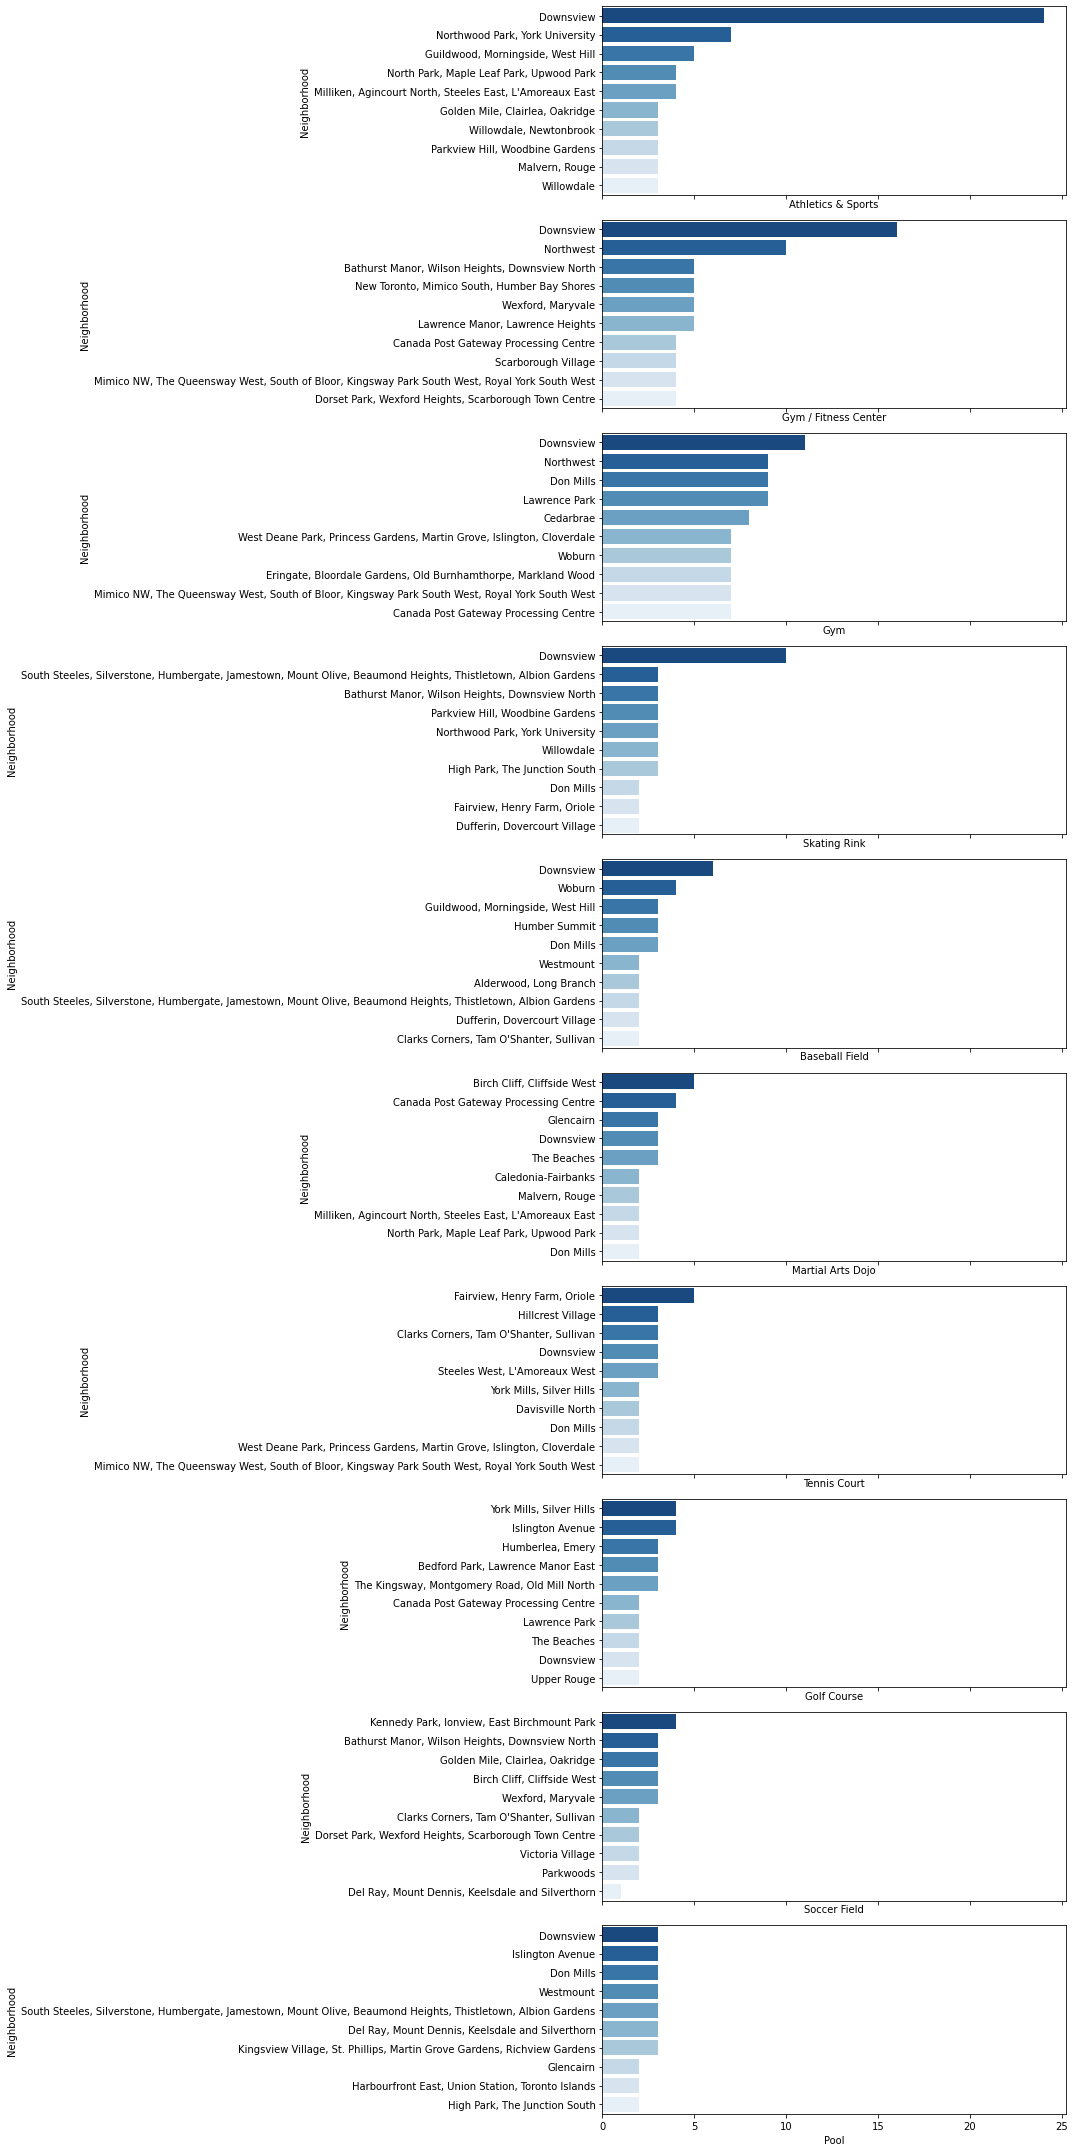

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(10, 1, figsize=(15,30), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_sport.index.values.tolist()):
    data = venue_counts_sport[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
Toronto_grouped_sport = Toronto_onehot_sport.groupby('Neighborhood').mean().reset_index()
Toronto_grouped_sport

,Neighborhood,Athletics & Sports,Baseball Field,Golf Course,Gym,Gym / Fitness Center,Martial Arts Dojo,Pool,Skating Rink,Soccer Field,Tennis Court,Yoga Studio
0,Agincourt,0.076923,0.000000,0.000000,0.461538,0.153846,0.076923,0.153846,0.076923,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.133333,0.133333,0.000000,0.133333,0.266667,0.000000,0.133333,0.066667,0.066667,0.000000,0.066667
2,"Bathurst Manor, Wilson Heights, Downsview North",0.100000,0.000000,0.050000,0.100000,0.250000,0.050000,0.000000,0.150000,0.150000,0.000000,0.150000
3,Bayview Village,0.200000,0.000000,0.100000,0.200000,0.000000,0.000000,0.100000,0.100000,0.000000,0.200000,0.100000
4,"Bedford Park, Lawrence Manor East",0.176471,0.000000,0.176471,0.235294,0.058824,0.058824,0.000000,0.058824,0.058824,0.117647,0.058824
5,Berczy Park,0.000000,0.000000,0.000000,0.500000,0.166667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.125000,0.062500,0.125000,0.125000,0.000000,0.312500,0.062500,0.000000,0.187500,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.142857,0.285714,0.000000,0.285714,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
8,Business reply mail Processing Centre,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.833333,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000


#### Let's confirm the new size

#### Let's write a function to sort the venues in descending order.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [40]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  
        
columns

['Neighborhood',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue']

In [41]:
# create a new dataframe
neighborhoods_venues_sorted_sport = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_sport['Neighborhood'] = Toronto_grouped_sport['Neighborhood']
for ind in np.arange(Toronto_grouped_sport.shape[0]):
    neighborhoods_venues_sorted_sport.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped_sport.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_sport.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Gym,Pool,Gym / Fitness Center
1,"Alderwood, Long Branch",Gym / Fitness Center,Pool,Gym
2,"Bathurst Manor, Wilson Heights, Downsview North",Gym / Fitness Center,Yoga Studio,Soccer Field
3,Bayview Village,Tennis Court,Gym,Athletics & Sports
4,"Bedford Park, Lawrence Manor East",Gym,Golf Course,Athletics & Sports


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [42]:
Toronto_grouped_clustering_sport = Toronto_grouped_sport.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [43]:
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering_sport)
    sum_of_squared_distances.append(kmeans.inertia_)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

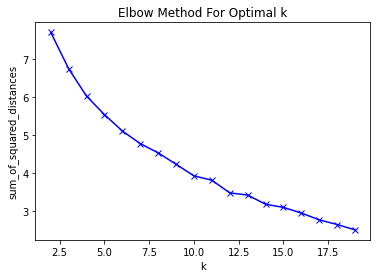

In [44]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [45]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering_sport)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering_sport, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

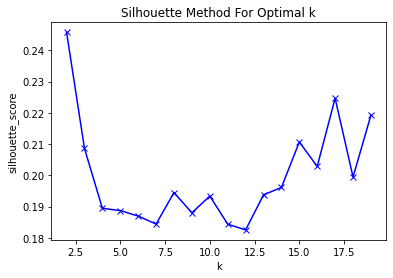

In [46]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [47]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.245799,2
1,0.208602,3
2,0.189436,4
3,0.188725,5
4,0.186960,6
5,0.184410,7
6,0.194479,8
7,0.188017,9
8,0.193366,10
9,0.184368,11


### Let's set number of clusters = 3

In [48]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering_sport)

print(Counter(kmeans.labels_))

Counter({0: 42, 1: 31, 2: 25})


Let's create a new dataframe that includes the cluster as well as the top 3 venues for each neighborhood.

In [49]:
# add clustering labels
try:
    neighborhoods_venues_sorted_sport.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted_sport.insert(0, 'Cluster Labels', kmeans.labels_)

In [50]:
neighborhoods_venues_sorted_sport.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1,Agincourt,Gym,Pool,Gym / Fitness Center
1,2,"Alderwood, Long Branch",Gym / Fitness Center,Pool,Gym
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Gym / Fitness Center,Yoga Studio,Soccer Field
3,0,Bayview Village,Tennis Court,Gym,Athletics & Sports
4,0,"Bedford Park, Lawrence Manor East",Gym,Golf Course,Athletics & Sports


In [51]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_sport = neighborhoods_venues_sorted_sport.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged_sport.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,1,Agincourt,Gym,Pool,Gym / Fitness Center,M1S,Scarborough,43.794200,-79.262029
1,2,"Alderwood, Long Branch",Gym / Fitness Center,Pool,Gym,M8W,Etobicoke,43.602414,-79.543484
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Gym / Fitness Center,Yoga Studio,Soccer Field,M3H,North York,43.754328,-79.442259
3,0,Bayview Village,Tennis Court,Gym,Athletics & Sports,M2K,North York,43.786947,-79.385975
4,0,"Bedford Park, Lawrence Manor East",Gym,Golf Course,Athletics & Sports,M5M,North York,43.733283,-79.419750


Finally, let's visualize the resulting clusters

In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_sport['Latitude'], Toronto_merged_sport['Longitude'], Toronto_merged_sport['Neighborhood'], Toronto_merged_sport['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [53]:
required_column_indices = [2,3,6]
required_column = [list(Toronto_merged_sport.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,6]

#### Cluster 0

In [54]:
cluster_0 = Toronto_merged_sport.loc[Toronto_merged_sport['Cluster Labels'] == 0, Toronto_merged_sport.columns[1:12]]
cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Postalcode,Borough,Latitude,Longitude
3,Bayview Village,Tennis Court,Gym,Athletics & Sports,M2K,North York,43.786947,-79.385975
4,"Bedford Park, Lawrence Manor East",Gym,Golf Course,Athletics & Sports,M5M,North York,43.733283,-79.419750
6,"Birch Cliff, Cliffside West",Martial Arts Dojo,Soccer Field,Gym,M1N,Scarborough,43.692657,-79.264848
7,"Brockton, Parkdale Village, Exhibition Place",Gym,Baseball Field,Skating Rink,M6K,West Toronto,43.636847,-79.428191
8,Business reply mail Processing Centre,Soccer Field,Skating Rink,Gym,M7Y,East Toronto,43.662744,-79.321558


In [55]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Gym                   21
Athletics & Sports     6
Tennis Court           5
Pool                   4
Golf Course            3
Skating Rink           1
Yoga Studio            1
Soccer Field           1
Martial Arts Dojo      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Gym                     10
Pool                     8
Yoga Studio              6
Skating Rink             3
Soccer Field             3
Golf Course              3
Tennis Court             3
Baseball Field           3
Gym / Fitness Center     2
Martial Arts Dojo        2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York         14
Scarborough        10
Etobicoke           6
Central Toronto     5
West Toronto        2
East Toronto        2
York                2
Mississauga         1
East York           1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 1

In [56]:
cluster_1 = Toronto_merged_sport.loc[Toronto_merged_sport['Cluster Labels'] == 1, Toronto_merged_sport.columns[1:12]]
cluster_1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,Agincourt,Gym,Pool,Gym / Fitness Center,M1S,Scarborough,43.794200,-79.262029
5,Berczy Park,Gym,Pool,Gym / Fitness Center,M5E,Downtown Toronto,43.644771,-79.373306
9,"CN Tower, King and Spadina, Railway Lands, Har...",Gym,Pool,Yoga Studio,M5V,Downtown Toronto,43.628947,-79.394420
12,Cedarbrae,Gym,Gym / Fitness Center,Skating Rink,M1H,Scarborough,43.773136,-79.239476
13,Central Bay Street,Gym,Pool,Gym / Fitness Center,M5G,Downtown Toronto,43.657952,-79.387383


In [57]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Gym                     23
Gym / Fitness Center     6
Pool                     2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Gym / Fitness Center    14
Pool                     8
Gym                      6
Skating Rink             2
Yoga Studio              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Downtown Toronto    18
Central Toronto      4
Scarborough          3
Etobicoke            3
East Toronto         2
York                 1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 3

In [58]:
cluster_2 = Toronto_merged_sport.loc[Toronto_merged_sport['Cluster Labels'] == 2, Toronto_merged_sport.columns[1:12]]
cluster_2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",Gym / Fitness Center,Pool,Gym,M8W,Etobicoke,43.602414,-79.543484
2,"Bathurst Manor, Wilson Heights, Downsview North",Gym / Fitness Center,Yoga Studio,Soccer Field,M3H,North York,43.754328,-79.442259
10,Caledonia-Fairbanks,Gym / Fitness Center,Yoga Studio,Pool,M6E,York,43.689026,-79.453512
14,Christie,Gym / Fitness Center,Baseball Field,Yoga Studio,M6G,Downtown Toronto,43.669542,-79.422564
21,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Pool,Athletics & Sports,Yoga Studio,M6M,York,43.691116,-79.476013


In [59]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Gym / Fitness Center    15
Skating Rink             4
Athletics & Sports       4
Soccer Field             2
Yoga Studio              2
Pool                     1
Martial Arts Dojo        1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Gym / Fitness Center    7
Pool                    5
Yoga Studio             5
Gym                     4
Skating Rink            3
Athletics & Sports      3
Baseball Field          1
Soccer Field            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York          10
West Toronto         4
Scarborough          4
East York            4
Etobicoke            3
York                 2
Downtown Toronto     1
East Toronto         1
Name: Borough, dtype: int64
---------------------------------------------
